In [50]:
using Plots, Random, FFTW, Colors, Statistics, LinearAlgebra, EllipsisNotation, Wavelets, PaddedViews,
    AbstractOperators, OffsetArrays, PyCall, Serialization, Distributed, JLD

‚îå Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
‚îî @ Base loading.jl:1278


## Read Data

In [2]:
d‚ÇÅ, d‚ÇÇ, d‚ÇÉ, m = 300, 224, 48, 4
kSpace_orig = Array{ComplexF32}(undef, d‚ÇÅ, d‚ÇÇ, d‚ÇÉ, m)
read!("../data.dat", kSpace_orig)
kSpace_orig = ntoh.(kSpace_orig) # big-endian to system default
kSpace_CF64_orig = ComplexF64.(kSpace_orig);

## Prepare Data

In [3]:
image4D_shifted_orig = abs.(ifft(kSpace_CF64_orig, [1,2,3]))            # Discard phase
image4D_shifted = image4D_shifted_orig ./ maximum(image4D_shifted_orig) # Normalize data
image4D = ifftshift(image4D_shifted, (1,3));                        # fftshift image (for visualization)
kSpace = rfft(image4D, [1,2,3]);                                          # Simulate measurement

In [51]:
@save "data.jld" image4D kSpace

In [4]:
imSize, imType, kSize, kType = size(image4D), eltype(image4D), size(kSpace), eltype(kSpace)

((300, 224, 48, 4), Float64, (151, 224, 48, 4), Complex{Float64})

## Visualize

In [5]:
function imshow(img::Array{T, 2}; shift = false) where T<:Number
    shift ? 
        plot(Gray.(abs.(fftshift(img, [1]))'), seriestype=:image) :
        plot(Gray.(abs.(img)'), seriestype=:image)
end

imshow (generic function with 1 method)

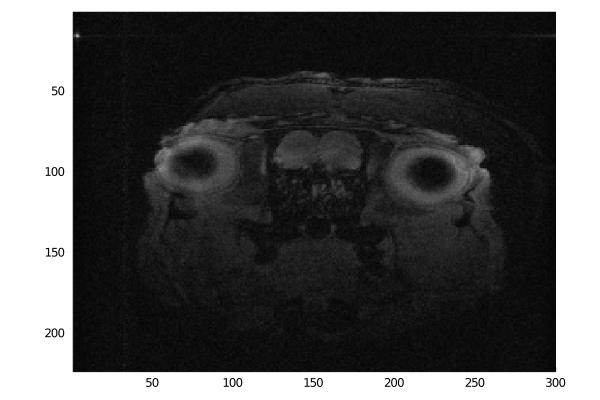

In [6]:
imshow(mean(image4D, dims = 4)[..,1,1])

## Simulate Measurement

### Generate potential density function (pdf)
**Goal:** Generate a pdf that satisfies the following criteria:
 1. Values of pdf are valid probability values (i.e. they are in the rage of $[0,1]$)
 1. There is an area in the middle of the image which has a predefined radius, and inside that area we perform no undersampling
 1. Left to the fully sampled area, the probability should be proportional to the distance from the center raised to the `p`th power
 1. Right to the fully sampled area, the probability should be $0$.
 1. Integral of the pdf normalized by the area of the support of the pdf has to be equal to the the undersampling factor
   - That, of course, violates the definition of pdf
   - so actually it is only a pdf-like function that maps each pixel (in k-space) to a probability value which tells us, how likely we will pick that value during undersampling
   - In other words, we can say that the expected number of undersampled values should be equal to the undersampling factor times the area of the support of the pdf
   
**Symbolic calculation:**

1-3rd conditions above:
$$
PDF: [-1,1] \rightarrow [0,1],
PDF(x) = \begin{cases}
(1-|x|)^p + b : x < -r \\
1 : -r \le x \le r \\
(1-|x|)^p + b : r < x
\end{cases}$$

4th condition above:
$$uf = \frac{1}{2}\left(\int_{-1}^{1} PDF(x) dx\right) = \frac{1}{2}\left(\int_{-1}^{-r} \left[(1+x)^p + b\right] dx + \int_{-r}^{r} 1 dx + \int_{r}^{1} \left[(1+x)^p + b\right] dx \right) = \frac{(1-r)^{p+1}}{p+1} + b(1-r) + r$$

Calculating bias:
$$b = \frac{uf - \frac{(1-r)^{p+1}}{(p+1)} - r}{(1-r)}$$

**Input:**
 - `dataLength` - length of output vector
 - `p` - power of polynomial
 - `uf` - undersampling factor (e.g. 0.5 for half)
 - `normType` - 1 or 2 for L1 or L2 distance measure
 - `fs_radius` - radius of fully sampled center
 - `disp` - display output
 
**Output:**
 - the pdf
 
*Corresponding Matlab code:* `utils/genPDF.m`

In [7]:
function generatePDF(dataLength, uf; distType = 2, r = 0.1, max_p = 50, disp = false)
    pdf = nothing
    
    for p = 0:max_p

        fs_end = floor(Int, r * dataLength)

        pdf = ones(dataLength)
        distance_map = abs.(range(0, 1, length = dataLength))
        pdf[fs_end+1:end] = (1 .- distance_map[fs_end+1:end]).^p
        
        # shift the exponential part to fullfil condition 4
        diff = uf * dataLength - sum(pdf)
        diff < 0 && continue
        pdf[fs_end+1:end] .+= diff / (dataLength - fs_end)
        all(x -> 0 <= x <= 1, pdf) && break
    end
    
    (pdf isa Nothing || any(x -> x < 0 || 1 < x, pdf)) && error("infeasible with given parameters")
    
    collect(pdf)
end

generatePDF (generic function with 1 method)

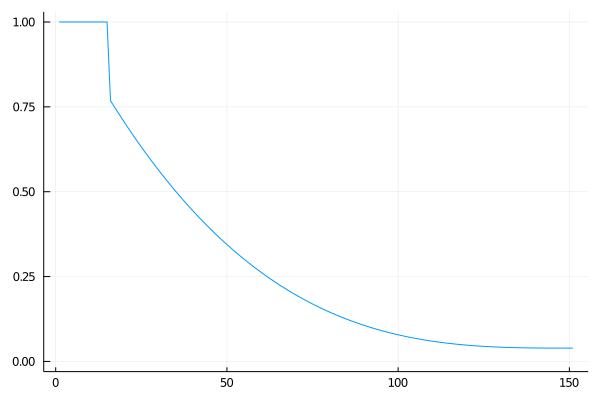

In [8]:
undersampling_rate, fully_sampled_radius = 0.3, 0.1
pdf = generatePDF(floor(Int,imSize[1]/2) + 1, undersampling_rate, r = fully_sampled_radius, disp = true)
plot(pdf, ylimits = [0,1], legend=false)

In [9]:
sum(pdf)*2, undersampling_rate * imSize[1]

(90.6, 90.0)

### Generating sampling mask
A Monte-Carlo algorithm to generate a sampling pattern with minimum peak interference. The number of samples will be sum(pdf) +- tol

**Why do we use Monte-Carlo algorithm?**
 - Finding optimal sampling scheme is combinatorial problem ‚Üí very difficult
 - Choosing samples random: incoherent and near-optimal solution
 - Monte-Carlo design procedure:
   - Choose a grid size based on desired resolution and FOV of object
   - Construct a probability density function (pdf) (e.g. using the "power of the distance from origin" rule)
   - Draw indices from the grid according to the constructed pdf
   - Repeat the previous step many times and pick a result with lower peak interference in TPSF (Transform Point Spread Function) to avoid samplings which are far from optimal
 - That sampling pattern can be re-used in future scans

**Inputs:**
 - `pdf` - probability density function to choose samples from
 - `iter` - number of tries
 - `tol`  - the deviation from the desired number of samples in samples
 
**Output:**
 - sampling pattern
 
*Corresponding Matlab code:* `utils/genSampling.m`

In [10]:
function generate_mask(pdf_2D, iter, tol; max_inner_iter = 100)
    function generate_2D_mask(pdf)
        mask = nothing
        for i in 1:max_inner_iter
            mask = [rand() < e for e in pdf]
            diff = abs(sum(mask) - sum(pdf))
            diff < tol*length(mask) && break
            i == max_inner_iter && error("infeasible with given parameters")
        end
        return mask
    end
    
    function extend_to_3D(mask)
        permutedims(repeat(mask, 1, 1, imSize[2]), [1,3,2])
    end
    
    masks = [generate_2D_mask(pdf_2D) for i = 1:iter]
    F‚Åª¬π‚Çò‚Çê‚Çõ‚Çñ‚Çõ = [ifft(mask./pdf_2D) for mask in masks]                    # Inverse Fourier transform
    TPSF‚Çò‚Çê‚Çì = [maximum(abs.(F‚Åª¬π‚Çò‚Çê‚Çõ‚Çñ[2:end])) for F‚Åª¬π‚Çò‚Çê‚Çõ‚Çñ in F‚Åª¬π‚Çò‚Çê‚Çõ‚Çñ‚Çõ] # height of larges sidelobe
    
    top_list = sort(TPSF‚Çò‚Çê‚Çì)[1:imSize[4]]
    selected_masks = [findfirst(isequal(elem), TPSF‚Çò‚Çê‚Çì) for elem in top_list]
    cat([extend_to_3D(masks[i]) for i in selected_masks]..., dims = 4) .== 1
end

generate_mask (generic function with 1 method)

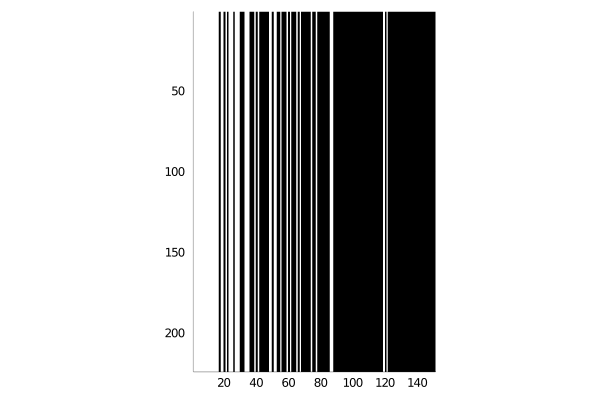

In [11]:
pdf_2D = pdf * ones(imSize[3])'
mask = generate_mask(pdf_2D, 50, 0.01)
imshow(mask[..,1,1] .* 1)

In [12]:
plan = plan_rfft(image4D, [1,2,3])
fft_temp = similar(plan * image4D)
inv_plan = plan_irfft(fft_temp, imSize[1], [1,2,3]);
normalizer = ‚àö(prod(imSize[1:3]) / 2)
F·µ§ = MyLinOp(imType, imSize, kType, kSize,
    (b, x) -> b .= 1/normalizer .* mask .* mul!(b, plan, x),
    (b, x) -> b .= normalizer .* mul!(b, inv_plan, fft_temp .= x))

A  ‚Ñù^(300, 224, 48, 4) -> ‚ÑÇ^(151, 224, 48, 4) 

In [13]:
y = F·µ§ * image4D;

In [14]:
image3D = sum(image4D, dims = 4)
image3D_norm = norm(image3D)
mse_temp = similar(image3D)
mse(img) = norm(sum!(mse_temp, img) .-= image3D) / image3D_norm

mse (generic function with 1 method)

## Baseline: Zero-filling reconstruction

In [15]:
image4D_zf = F·µ§' * y
@show mse(image4D_zf);

mse(image4D_zf) = 0.13823765140015135


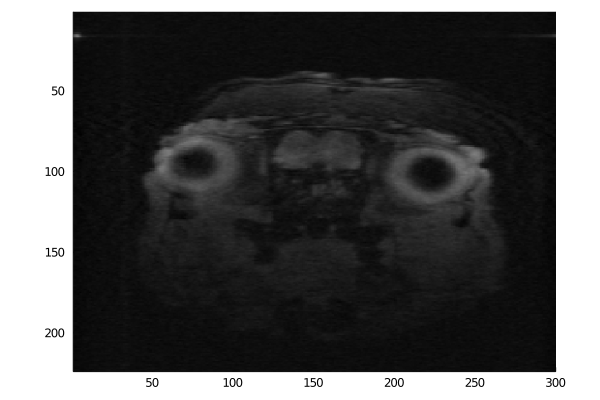

In [16]:
imshow(mean(image4D_zf, dims = 4)[..,1,1])

## Compressed Sensing

In [23]:
norm‚ÇÅ(v) = norm(v, 1)
norm‚ÇÇ(x) = norm(x)
norm‚ÇÇ¬≤(x) = abs(vec(x)' * vec(x))

norm‚ÇÇ¬≤ (generic function with 1 method)

## Sparsifying transform

In [19]:
wt = wavelet(WT.Daubechies{4}(), WT.Filter, WT.Periodic)
transformed_size = ((2 .^ (ceil.(Int, log2.(imSize[1:3]))))..., imSize[4])
temp_wavelet = similar(image3D, transformed_size)
oneTo(x) = 1:x
Œ® = MyLinOp(imType, imSize, transformed_size,
    (b, x) -> begin
        img = PaddedView(0, x, size(b))
        Threads.@threads for i in 1:imSize[4]
            @views dwt!(b[..,i], img[..,i], wt)
        end
        b
    end,
    (b, x) -> begin
        Threads.@threads for i in 1:imSize[4]
            @views idwt!(temp_wavelet[..,i], x[..,i], wt)
        end
        b .= @view temp_wavelet[oneTo.(imSize)...]
    end)

A  ‚Ñù^(300, 224, 48, 4) -> ‚Ñù^(512, 256, 64, 4) 

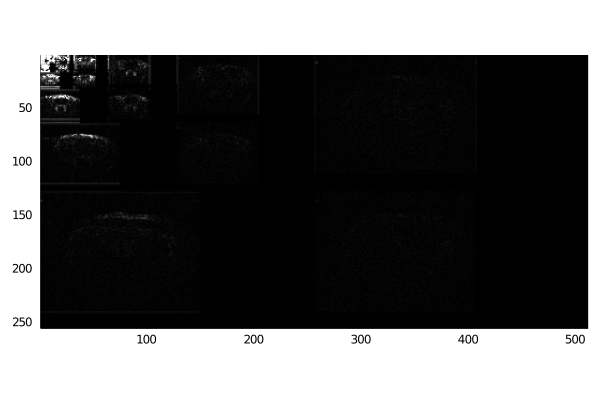

In [20]:
test = Œ® * image3D
imshow(mean(test, dims = 4)[..,1,1])

### Total Variance

In [21]:
function _finite_differences!(Œîx, x, d)
    last = size(Œîx, d)
    ùüò = zero(eltype(x))
    for i in axes(Œîx, d)
        if i != last
            selectdim(Œîx, d, i) .= selectdim(x, d, i) .- selectdim(x, d, i+1)
        else
            selectdim(Œîx, d, i) .= ùüò
        end
    end
end
function _second_order_finite_differences!(Œîx, x, d, overwrite)
    last = size(Œîx, d)
    ùüò, ùüô = zero(eltype(x)), one(eltype(x))
    for i in axes(Œîx, d)
        if overwrite
            if i == 1
                selectdim(Œîx, d, i) .= -ùüô .* selectdim(x, d, i)
            elseif i != last
                selectdim(Œîx, d, i) .= selectdim(x, d, i) .- selectdim(x, d, i-1)
            else
                selectdim(Œîx, d, i) .= ùüò
            end
        else
            if i == 1
                selectdim(Œîx, d, i) .-= selectdim(x, d, i)
            elseif i != last
                selectdim(Œîx, d, i) .+= selectdim(x, d, i) .- selectdim(x, d, i-1)
            end
        end
    end
    Œîx
end

_second_order_finite_differences! (generic function with 1 method)

In [22]:
TV = MyLinOp(imType, imSize, (imSize[1:3]..., 3, imSize[end]),
    (‚àá, image) -> begin
        Threads.@threads for i in 1:imSize[end]
            for d in 1:ndims(image)-1
                @views _finite_differences!(‚àá[..,d, i], image[..,i], d)
            end
        end
        ‚àá
    end,
    (‚àá, image) -> begin
        Threads.@threads for i in 1:imSize[end]
            for d in 1:ndims(‚àá)-1
                @views _second_order_finite_differences!(‚àá[..,i], image[..,d, i], d, d == 1) 
            end
        end
        ‚àá
    end)

A  ‚Ñù^(300, 224, 48, 4) -> ‚Ñù^(300, 224, 48, 3, 4) 

## Optimized Proximal Gradient Method

**Inputs:**
 - `x‚ÇÄ`: initial guess for minimizer
 - `f`: convex and smooth function with Lipshitz gradient $L$
 - `‚àáf`: gradient of function `f`
 - `g`: convex but non-smooth function
 - `prox_g`: proximity operator of function `g`
 - `maxIter`: number of iterations
 - `t`: step-size (ideally equal to $\frac{1}{L}$)
 - `restart`: reset $\theta_k$ to initial value if cost increases
 
**Initialization:** $\theta_0 = \zeta_0 = 1, t = 0.5$

for $k = 1, 2, ... , N$ do

 - $y_k \leftarrow x_{k-1} - t \nabla f(x_{k-1})$
 - $\theta_k \leftarrow \begin{cases} \frac{1+\sqrt{1 + 4\theta_{k-1}^2}}{2} : k < N \\ \frac{1+\sqrt{1 + 8\theta_{k-1}^2}}{2} : k = N \end{cases}$
 - $z_k \leftarrow y_k + \frac{\theta_{k-1}-1}{\theta_k}(y_k - y_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(y_k - x_{k-1}) + t \frac{\theta_{k-1}-1}{\gamma_{k-1} \theta_k}(z_{k-1} - x_{k-1})$
 - $\gamma_k \leftarrow t \frac{2\theta_{k-1} + \theta_{k-1} - 1}{\theta_k})$
 - $x_k \leftarrow prox_{g}(z_k, \gamma_k)$

end for 

**output:** $x_N$

In [24]:
function POGM(x‚ÇÄ, f, ‚àáf!, g, prox_g!; N = 10, L = 1, restart = true, verbose = false)
    
    dType = eltype(x‚ÇÄ)
    Œ∏‚Çñ‚Çã‚ÇÅ = Œ≥‚Çñ‚Çã‚ÇÅ = one(real(dType))
    x‚Çñ, x‚Çñ‚Çã‚ÇÅ, y‚Çñ‚Çã‚ÇÅ, y‚Çñ, z‚Çñ‚Çã‚ÇÅ, z‚Çñ, temp = [copy(x‚ÇÄ) for _ in 1:7]
    t = convert(real(dType), 1/2L)
    
    f_vec, g_vec, NMSE_vec = [OffsetVector{real(dType)}(undef, 0:N) for _ in 1:3]
    f_vec[0], g_vec[0], NMSE_vec[0] = f(x‚Çñ‚Çã‚ÇÅ), g(x‚Çñ‚Çã‚ÇÅ), mse(x‚Çñ‚Çã‚ÇÅ)
    if verbose
        println("k = 0, consistency = $(f_vec[0]), regularization: $(g_vec[0]), NMSE: $(NMSE_vec[0]), Œ∏‚Çñ: $Œ∏‚Çñ‚Çã‚ÇÅ")
    end
    
    for k in 1:N
        y‚Çñ .= x‚Çñ‚Çã‚ÇÅ .- t .* ‚àáf!(temp, x‚Çñ‚Çã‚ÇÅ)
        Œ∏‚Çñ = (1 + ‚àö(1 + (k < N ? 4 : 8)*Œ∏‚Çñ‚Çã‚ÇÅ^2))/2
        @. z‚Çñ = y‚Çñ + (Œ∏‚Çñ‚Çã‚ÇÅ-1)/Œ∏‚Çñ * (y‚Çñ - y‚Çñ‚Çã‚ÇÅ) + Œ∏‚Çñ‚Çã‚ÇÅ/Œ∏‚Çñ * (y‚Çñ - x‚Çñ‚Çã‚ÇÅ) +
                t * (Œ∏‚Çñ‚Çã‚ÇÅ-1)/(Œ≥‚Çñ‚Çã‚ÇÅ*Œ∏‚Çñ) * (z‚Çñ‚Çã‚ÇÅ - x‚Çñ‚Çã‚ÇÅ)
        Œ≥‚Çñ = t*(2Œ∏‚Çñ‚Çã‚ÇÅ + Œ∏‚Çñ‚Çã‚ÇÅ - 1)/Œ∏‚Çñ
        prox_g!(x‚Çñ, z‚Çñ, 1)
        
        f_vec[k], g_vec[k], NMSE_vec[k] = f(x‚Çñ), g(x‚Çñ), mse(x‚Çñ)
        if verbose
            println("k: $k, consistency: $(f_vec[k]), regularization: $(g_vec[k]), NMSE: $(NMSE_vec[k]), Œ∏‚Çñ: $Œ∏‚Çñ")
        end
        
        if restart && f_vec[k] + g_vec[k] > f_vec[k - 1] + g_vec[k - 1]
            Œ∏‚Çñ‚Çã‚ÇÅ = Œ∏‚Çñ = one(real(dType))
            verbose && println("   Restarted!")
        end
        
        x‚Çñ‚Çã‚ÇÅ, y‚Çñ‚Çã‚ÇÅ, z‚Çñ‚Çã‚ÇÅ, x‚Çñ, y‚Çñ, z‚Çñ = x‚Çñ, y‚Çñ, z‚Çñ, x‚Çñ‚Çã‚ÇÅ, y‚Çñ‚Çã‚ÇÅ, z‚Çñ‚Çã‚ÇÅ
        Œ∏‚Çñ‚Çã‚ÇÅ, Œ≥‚Çñ‚Çã‚ÇÅ = Œ∏‚Çñ, Œ≥‚Çñ
    end
    
    x‚Çñ, f_vec .+ g_vec, NMSE_vec
end

POGM (generic function with 1 method)

In [25]:
function power_method!(x, op, maxIter)
    Œª‚Çò‚Çê‚Çì = Inf
    for i in 1:maxIter
        mul!(x, op, x)
        Œª‚Çò‚Çê‚Çì = norm(x, 2)
        x ./= Œª‚Çò‚Çê‚Çì
    end
    Œª‚Çò‚Çê‚Çì
end

power_method! (generic function with 1 method)

## Run reconstructions

In [42]:
pos(x) = x < 0 ? zero(x) : x
Œõ!(v, p) = @. v = sign(v) * pos(abs(v) - p)
SVT!(A, p) = begin
    F = svd!(A)
    A .= F.U * Diagonal(Œõ!(F.S, p)) * F.Vt
end

Œª‚ÇÅ = convert(real(imType), 0.0005)     # Weight for Transform L1 penalty
Œª‚ÇÇ = convert(real(imType), 0.0002)      # Weight for TV penalty
Œª‚ÇÉ = convert(real(imType), 0.02)      # Weight for low-rank penalty

prox_tv = pyimport("prox_tv")
temp‚ÇÅ, temp‚ÇÇ, temp‚ÇÉ, temp‚ÇÑ = F·µ§ * image4D, Œ® * image4D, TV * image4D, similar(image4D)
f_pogm(x) = norm‚ÇÇ¬≤(mul!(temp‚ÇÅ, F·µ§, x) .-= y)
‚àáf_pogm!(b, x) = begin
    #2 * F·µ§' * (F·µ§ * x - y)
    mul!(temp‚ÇÅ, F·µ§, x)
    temp‚ÇÅ .-= y
    mul!(b, F·µ§', temp‚ÇÅ)
    b .*= 2
end
g_pogm(x) = Œª‚ÇÅ * norm(mul!(temp‚ÇÇ, Œ®, x), 1) + Œª‚ÇÇ * norm(mul!(temp‚ÇÉ, TV, x), 1) +
                    Œª‚ÇÉ * sum(svdvals(reshape(x, :, imSize[end])))
prox_g_pogm!(b, x, Œ≥) = begin
    for i in 1:imSize[end]
        @views temp‚ÇÑ[..,i] .= prox_tv.tvgen(x[..,i], (Œ≥*Œª‚ÇÇ, Œ≥*Œª‚ÇÇ, Œ≥*Œª‚ÇÇ), (1, 2, 3), (1, 1, 1))
    end
    mul!(b, Œ®', Œõ!(mul!(temp‚ÇÇ, Œ®, temp‚ÇÑ), Œ≥ * Œª‚ÇÅ))
    SVT!(reshape(b, :, imSize[end]), Œª‚ÇÉ)
end

#b = similar(image2D_zf)
#Œª‚Çò‚Çê‚Çì = power_method!(b, F·µ§' * F·µ§, 10)

@time image4D_pogm, f_vec_pogm, NMSE_vec_pogm = POGM(image4D_zf, f_pogm, ‚àáf_pogm!, g_pogm, prox_g_pogm!,
    N = 5, L = 1, verbose = true);

k = 0, consistency = 0.23789670455743395, regularization: 309.7965610516825, NMSE: 0.13823765140015135, Œ∏‚Çñ: 1.0
k: 1, consistency: 13.513913980988015, regularization: 294.55163643747284, NMSE: 0.1384966180139406, Œ∏‚Çñ: 1.618033988749895
k: 2, consistency: 0.07379922225645318, regularization: 305.5889918239549, NMSE: 0.137780022882899, Œ∏‚Çñ: 2.193527085331054
k: 3, consistency: 6.922245732259293, regularization: 295.0875061703285, NMSE: 0.13787364023326548, Œ∏‚Çñ: 2.749791340120445
k: 4, consistency: 0.35580302803111996, regularization: 301.1055738883366, NMSE: 0.13732892302437946, Œ∏‚Çñ: 3.2948796779470473
k: 5, consistency: 6.600055757878891, regularization: 292.57465940892644, NMSE: 0.13737382030019563, Œ∏‚Çñ: 5.1864127202260875
 82.118587 seconds (68.63 M allocations: 4.271 GiB, 6.81% gc time)


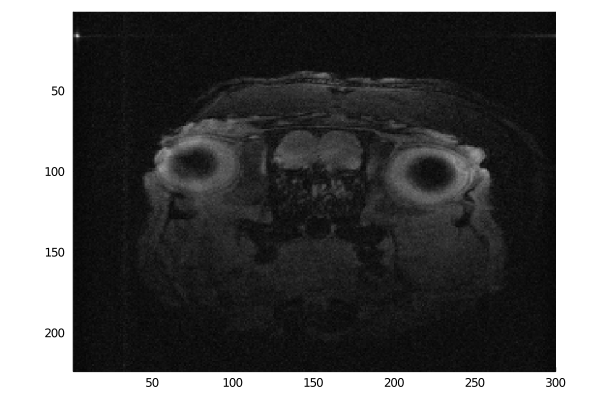

In [29]:
image2D = mean(image4D, dims = 4)[..,1,1]
imshow(image2D ./ maximum(image2D))

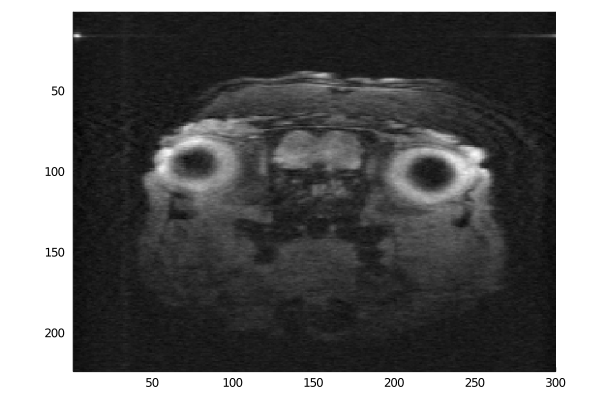

In [30]:
image2D_zf = mean(image4D_zf, dims = 4)[..,1,1]
imshow(image2D_zf ./ maximum(image2D_zf))

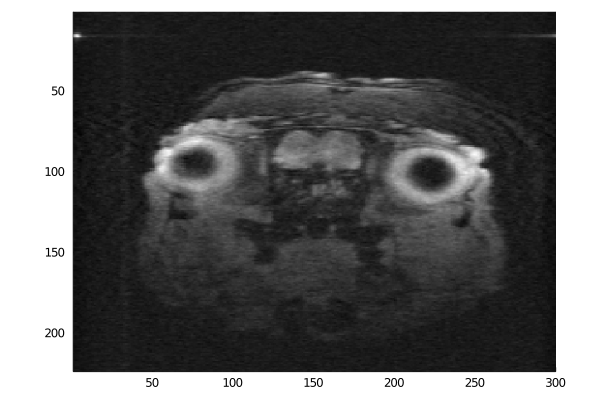

In [43]:
image2D_pogm = mean(image4D_pogm, dims = 4)[..,1,1]
imshow(image2D_pogm ./ maximum(image2D_pogm))

In [44]:
mse(image4D_zf), mse(image4D_pogm)

(0.13823765140015135, 0.13732892302437946)

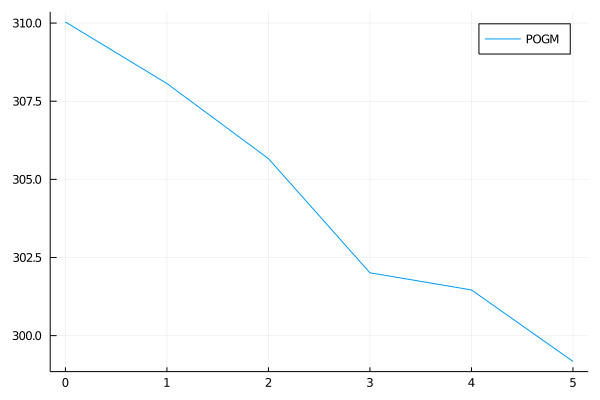

In [45]:
plot(f_vec_pogm, label="POGM")

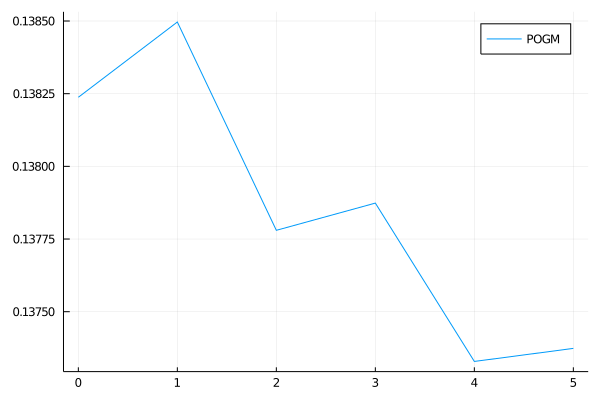

In [46]:
plot(NMSE_vec_pogm, label="POGM")